In [82]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
import cv2

In [83]:
pretrained_model = "checkpoint_model.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [84]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNISTのTest datasetと dataloaderの定義
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])), 
        batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [85]:
def im_is_black(image):
    if image < torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [86]:
def im_is_white(image):
    if image >= torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [87]:
def character_search(image):
    image_copy = copy.deepcopy(image)
    for x in range(28):
        for y in range(28):
            if im_is_black(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if (x + i != -1) and (x + i != 28) and (y + j != -1) and (y + j != 28):
                            if im_is_white(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
            elif im_is_white(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if (x + i != -1) and (x + i != 28) and (y + j != -1) and (y + j != 28):
                            if im_is_black(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
    image_chain = list(itertools.chain.from_iterable(image_copy))
    return image_chain

In [88]:
def attack(image, data_grad, max_index_list, target, loss_old):
    stop = 0
    data_grad_chain = list(itertools.chain.from_iterable(data_grad[0][0]))
    character_coordinate = character_search(image.data[0][0])
    for i in range(784):
        if character_coordinate[i] == torch.Tensor([0]).to("cuda"):
            data_grad_chain[i] = torch.Tensor([0]).to("cuda")
    for j in max_index_list:
        data_grad_chain[j] = torch.Tensor([0]).to("cuda")
    grad_sorted = sorted(list(map(abs, data_grad_chain)), reverse=True)
    for k in grad_sorted:
        grad_max_index = list(map(abs, data_grad_chain)).index(k)
        image.requires_grad = False
        if (data_grad_chain[grad_max_index] > 0 and image[0][0][grad_max_index // 28][grad_max_index - 28 * (grad_max_index // 28)] < 0) or (data_grad_chain[grad_max_index] < 0 and image[0][0][grad_max_index // 28][grad_max_index - 28 * (grad_max_index // 28)] > 0):
            image[0][0][grad_max_index // 28][grad_max_index - 28 * (grad_max_index // 28)] *= -1
            output = model(image)
            if F.nll_loss(output, target) < loss_old:
                image[0][0][grad_max_index // 28][grad_max_index - 28 * (grad_max_index // 28)] *= -1
                continue
            else:
                max_index_list.append(grad_max_index)
                break
    else:
        stop = 1
    return image, max_index_list, stop, output

In [89]:
def test( model, device, test_loader):

    # 精度カウンター
    correct = 0
    # count = 0
    count_list = [0] * 10

    adv_examples = []
    # i=0
    dirname_grad = "../PGD_MNIST_upd/grad/"
    dirname_org = "../PGD_MNIST_upd/org/"
    dirname_adv = "../PGD_MNIST_upd/adv/"
    dirname_pro = "../PGD_MNIST_upd/progress/"


    # テスト用データセット内の全てのサンプルをループします
    for data, target in test_loader:
        # i+=1
        # if i==150:
        #     break
        # データとラベルをデバイス（CPUもしくはGPU）に送信します
        data, target = data.to(device), target.to(device)
        data = (data >= torch.Tensor([0]).to("cuda")).float() - (data < torch.Tensor([0]).to("cuda")).float()

        # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
        data.requires_grad = True

        # データをモデルに順伝播させます
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        suuzi = 6
        if init_pred.item() != target.item() or init_pred.item() != suuzi:
            continue

        data_copy = data.detach().clone()
        for j in [dirname_grad, dirname_org, dirname_adv, dirname_pro]:
                    for k in ["0/", "1/", "2/", "3/", "4/", "5/", "6/", "7/", "8/", "9/"]:
                        os.makedirs(j + k, exist_ok=True)

        # count += 1
        # print(count)
        # if count <= 433:
        #     continue
        count_list[init_pred.item()] += 1
        os.makedirs(dirname_pro + "{}/{}".format(suuzi, count_list[init_pred.item()]), exist_ok=True)
        for px in range(1, 785):
            data.requires_grad = True
            # 損失を計算します
            loss = F.nll_loss(output, target)
            print("loss:{}".format(loss))
            # 既存の勾配を全てゼロにします
            model.zero_grad()
            # 逆伝播させてモデルの勾配を計算します
            loss.backward()
            # データの勾配を取得します
            data_grad = data.grad.data
            if px == 1:
                max_index = []
                #勾配のヒートマップ
                grad_map = data_grad.squeeze().detach().cpu().numpy()
                grad_map_abs = np.abs(grad_map)
                plt.xticks([], [])
                plt.yticks([], [])
                plt.imsave(dirname_grad + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), grad_map_abs, cmap="Reds")
            perturbed_data, max_index, stop, output = attack(data, data_grad, max_index, target, loss)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_pro + "{}/{}".format(suuzi, count_list[init_pred.item()]) + "/{}.png".format(px), perturbed_data.squeeze().detach().cpu().numpy(), cmap="gray")
            print("px:{}".format(px))
            pred = output.max(1, keepdim=True)[1]
            data = perturbed_data

            #勾配の絶対値のグラフ
            # sns.set()
            # sns.set_style('whitegrid')
            # sns.set_palette('gray')
            # data_grad = data_grad.cpu()
            # data_grad = list(list(map(abs, itertools.chain.from_iterable(data_grad[0][0]))))
            # data_grad.sort(reverse=True)
            # x = np.array(list(range(1, 785)))
            # y = np.array(data_grad)
            # fig = plt.figure()
            # ax = fig.subplots()
            # ax.plot(x, y)
            # ax.set_xlabel('absolute gradient rank')
            # ax.set_ylabel('absolute gradient')
            # fig.savefig(dirname_grad + "{}/graph{}.png".format(init_pred.item(), count_list[init_pred.item()]))

            if pred.item() != target.item():
                break
            elif stop == 1:
                break
        
        final_pred = pred

        org = data_copy.squeeze().detach().cpu().numpy()
        adv = perturbed_data.squeeze().detach().cpu().numpy()
        

        #各条件を満たす画像の保存
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_org + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), org, cmap="gray")
        
        
        os.makedirs(dirname_adv + "{}/{}→{}/".format(init_pred.item(), init_pred.item(), final_pred.item()), exist_ok=True)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_adv + "{}/{}→{}/{}.png".format(init_pred.item(), init_pred.item(), final_pred.item(), count_list[init_pred.item()]), adv, cmap="gray")


        if (final_pred.item() != target.item()):
            # あとで可視化するために敵対的サンプルのうちいくつかを保存
            if len(adv_examples) < 25:
                adv_examples.append( (init_pred.item(), final_pred.item(), org, adv))
                # if len(adv_examples) == 25:
                #     break


    # # epsilonごとの最終的な精度を算出
    # final_acc = correct/float(len(test_loader))
    # print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

    # # 精度と敵対的サンプルを返却
    # return final_acc, adv_examples

loss:0.0
px:1
loss:3.576278118089249e-07
px:2
loss:2.50339189733495e-06
px:3
loss:7.152531907195225e-06
px:4
loss:1.9550132492440753e-05
px:5
loss:5.98412734689191e-05
px:6
loss:0.00015507926582358778
px:7
loss:0.0006444760947488248
px:8
loss:0.0011194637045264244
px:9
loss:0.003947918768972158
px:10
loss:0.005618850234895945
px:11
loss:0.013737066648900509
px:12
loss:0.029072096571326256
px:13
loss:0.029487015679478645
px:14
loss:0.047304119914770126
px:15
loss:0.0655897781252861
px:16
loss:0.14297808706760406
px:17
loss:0.18169495463371277
px:18
loss:0.27051064372062683
px:19
loss:0.37494096159935
px:20
loss:4.351044481154531e-05
px:1
loss:0.0002498314715921879
px:2
loss:0.0015461406437680125
px:3
loss:0.00762220611795783
px:4
loss:0.015400656498968601
px:5
loss:0.5897095203399658
px:6
loss:1.1920928244535389e-07
px:1
loss:9.536738616588991e-07
px:2
loss:7.986990567587782e-06
px:3
loss:4.279521817807108e-05
px:4
loss:0.00023719835735391825
px:5
loss:0.0017457258654758334
px:6
loss:0.

TypeError: cannot unpack non-iterable NoneType object

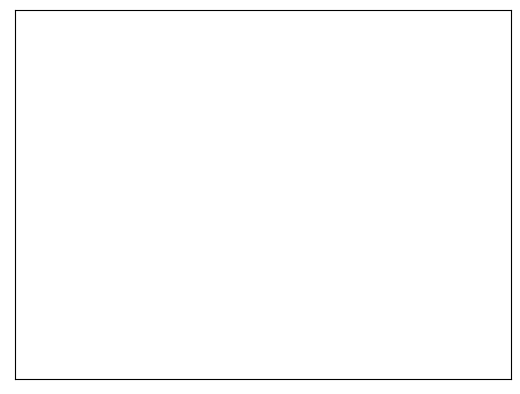

In [90]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
acc, ex = test(model, device, test_loader)
accuracies.append(acc)
examples.append(ex)

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv, org_ex, adv_ex = examples[0][j]
    plt.title("{}".format(orig), color="white")
    plt.imshow(org_ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, org_ex, adv_ex = examples[0][j]
    plt.title("{} -> {}".format(orig, adv), color="white")
    plt.imshow(adv_ex, cmap="gray")
plt.tight_layout()
plt.show()